<a href="https://colab.research.google.com/github/jancyrillmendoza/IBM-Data-Analysis/blob/main/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset Inspection

In [3]:
path = '/content/drive/Shareddrives/MSDS 501 Group 1/dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv'

# View Column Attribs
RAW = pd.read_csv(path)
RAW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

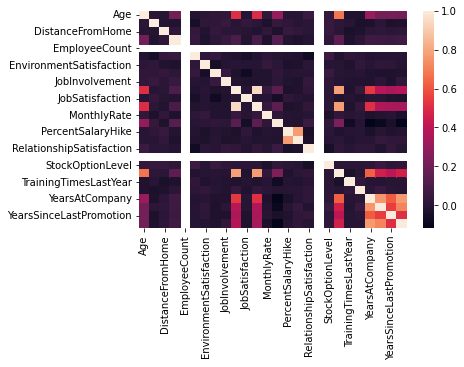

In [7]:
sns.heatmap(RAW.corr())
plt.show()

### Drop Irrelevant Features

In [8]:
data = RAW.drop(columns=['EmployeeCount', 'StandardHours', 'Over18',
                         'EmployeeNumber'])
data['Target'] = data['Attrition'].apply(lambda x: 0 if x == 'No' else 1)
data = data.drop(['Attrition'], axis=1)

### Separate Target (y) from its Features (x)

In [9]:
x = data.drop(columns=['Target'])
y = data['Target']

print(x.shape, y.shape)

(1470, 30) (1470,)


### Encode Categorical Features

In [10]:
def encode(dataframe):
  d = deepcopy(dataframe)
  for col in dataframe:
    dt = dataframe[col].dtype
    if(dt == 'object'):
      print('encoded:', col)
      # get all unique vals
      unique = d[col].unique()
      codes = {}
      for i, v in enumerate(unique):
        codes[v] = i
      d[col] = d[col].apply(lambda x: codes[x])
  return d

In [11]:
x = encode(x)

encoded: BusinessTravel
encoded: Department
encoded: EducationField
encoded: Gender
encoded: JobRole
encoded: MaritalStatus
encoded: OverTime


### Balance Target Class

In [12]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
# define oversampling strategy
smote = SMOTE()
x, y = smote.fit_resample(x, y)

print("after oversampling: ",Counter(y))

after oversampling:  Counter({1: 1233, 0: 1233})


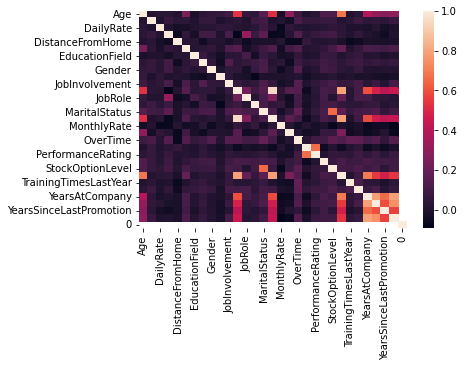

In [16]:
sns.heatmap(pd.concat([x, y]).corr())
plt.show()

### Remove Outliers

In [17]:
def winsorize(colname, df):
    q1 = np.percentile(df, 1)
    q3 = np.percentile(df, 99)
    out = []
    for i in df:
        if (i > q3 or i < q1 ) and i > 0:
            out.append(i) 
    if (len(out) != 0):
        print(colname, 'outliers: ', len(out))
    return out

def remove_outliers(df):
    for col in df.columns[1:]:
        if(df[col].dtype != 'object'):
            filter = winsorize(col, df[col])
            df = df[~df[col].isin(filter)]
    return df

cleaned = remove_outliers(pd.concat([x, y], axis=1))


DailyRate outliers:  49
HourlyRate outliers:  35
MonthlyIncome outliers:  48
MonthlyRate outliers:  48
PercentSalaryHike outliers:  17
TotalWorkingYears outliers:  20
YearsAtCompany outliers:  18
YearsInCurrentRole outliers:  22
YearsSinceLastPromotion outliers:  15
YearsWithCurrManager outliers:  16


In [18]:
x = cleaned.drop(columns=['Target'])
y = cleaned.Target

print(x.shape, y.shape)

(2178, 30) (2178,)


### Rescale Features

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for col in x:
    x[col] = x[col].astype(float)
    x[[col]] = scaler.fit_transform(x[[col]])

x.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.696731,-0.505018,0.881041,-1.128570,-1.135573,-0.746592,-1.014281,-0.404956,-1.026051,1.539966,...,-0.324072,-1.359725,-0.727391,-0.153424,-2.102322,-2.104101,0.165598,0.255963,-0.684497,0.616986
1,1.633447,1.289321,-1.386366,0.743498,-0.217601,-1.784957,-1.014281,0.524437,0.974611,-0.268086,...,3.085732,1.489679,0.525977,0.180400,0.355465,0.594004,1.088033,1.278878,-0.273912,1.293961
3,-0.239985,1.289321,1.680006,0.743498,-0.873295,1.330136,-1.014281,1.453830,-1.026051,-0.542033,...,-0.324072,0.539878,-0.727391,-0.153424,0.355465,0.594004,0.626816,1.278878,0.547258,-1.075451
4,-0.942522,-0.505018,-0.526790,0.743498,-1.004434,-1.784957,0.492097,-1.334349,0.974611,-1.418665,...,-0.324072,1.489679,0.525977,-0.487248,0.355465,0.594004,-0.756837,-0.425980,0.136673,-0.398476
5,-0.357075,1.289321,0.613801,0.743498,-1.004434,-0.746592,-1.014281,1.453830,0.974611,0.718124,...,-0.324072,0.539878,-0.727391,-0.153424,-0.463797,-0.755048,0.396207,1.278878,0.547258,0.955473


## Feature Selection

### Inspect Important Features (XGB, SVC, ExtraTrees, Logistic Regression)

In [20]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size = 0.2)

In [22]:
def plot_feature_scores(i, name):
    df = pd.DataFrame(i)
    plt.plot(df.nfeats, df.score)
    plt.title(name)
    plt.ylabel('score')
    plt.xlabel('nfeats')
    plt.xlim(np.max(df.nfeats)+1, 3)
    plt.show()

In [23]:
def get_model(type):
  if type == 'xgb':
    return XGBClassifier(learning_rate =0.2, objective='binary:logistic',
              random_state=6, nthread=4)
  elif type == 'et':
    return ExtraTreesClassifier(random_state=6)
  elif type == 'svc':
    return SVC(kernel='rbf', C=2, random_state=6)
  else:
    return LogisticRegression(random_state=6)

In [32]:
def graph_importance(features, fi):
  plt.rcParams["figure.figsize"] = (15,7)
  plt.figure()
  plt.title("Feature importances")
  plt.barh(features, fi,
        color="b", align="center")
  plt.gca().invert_yaxis()
  plt.show()

def get_importance(_t, _feats, _xtrain, _ytrain, _xtest, _ytest):
  model = get_model(_t)
  trained = model.fit(_xtrain[_feats], _ytrain)
  score = trained.score(_xtest[_feats], _ytest)
  features = []
  importances = []
  if _t == 'xgb':
    fi = model.get_booster().get_score(importance_type = 'weight')
    sf = pd.DataFrame.from_dict([fi]).T.sort_values(0, ascending=False)
    features = [ row.name for i, row in sf.iterrows()]
    importances = [ fi[i] for i, row in sf.iterrows() ]
  elif _t == 'et':
    fi = model.feature_importances_
    indices = np.flip(np.argsort(fi))
    features = [ _xtrain.columns[i] for i in indices ]
    importances = [ fi[i] for i in indices ]
  elif _t == 'svc':
    mean = permutation_importance(model, _xtest[_feats], _ytest).importances_mean
    feature_names = [ i for i in xtrain.columns]
    sorted_idx = mean.argsort()
    features = [feature_names[i] for i in np.flip(sorted_idx)]
    importances = [mean[i] for i in np.flip(sorted_idx)]
  elif _t == 'lr':
    coef = model.coef_[0]
    importance = []
    for i, v in enumerate(coef):
        importance.append({'feature' : _feats[i], 'importance': abs(v)})
    df = pd.DataFrame.from_dict(importance)
    df = df.sort_values('importance', ascending=False)
    features = [ row.feature for i, row in df.iterrows() ]
    importances = [ row.importance for i, row in df.iterrows() ]
  return (model, score, features, importances)

def feature_elimination(_t, _xtrain, _ytrain, _xtest, _ytest):
    _ = []
    best_model = 0
    feat_size = len(_xtrain.columns)
    feats = [ i for i in _xtrain.columns ]
    i = feat_size
    max = 0
    min_feats = 0

    # for average
    sum = 0.0
    iterations = 0.0
    while i >= 5:
        model, score, features, importances \
         = get_importance(_t, feats, _xtrain, _ytrain, _xtest, _ytest)
        if score >= max:
            max = score
            min_feats = len(feats)
            best_model = int(iterations)
        feats.pop()
        _.append({'model': model, 'score': score, 'nfeats': len(feats), 
                  'feats' : features, 'importances' :importances })
        i -= 1
        iterations += 1.0
        sum += score
    print('average accuracy: {} '.format(sum/iterations))
    print('max accuracy: {} minimum feats: {}'.format(max, min_feats))
    
    return ( _, best_model)

### Best XGB Feature Importance

average accuracy: 0.8532992237120679 
max accuracy: 0.9105504587155964 minimum feats: 20


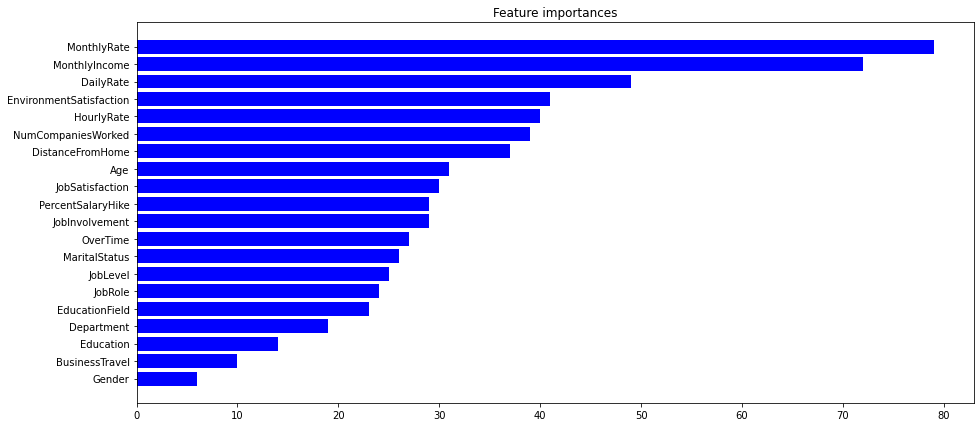

In [25]:
xgb_elim, xgb_best = feature_elimination('xgb', xtrain, ytrain, xtest, ytest)
best = xgb_elim[xgb_best]
graph_importance(best['feats'], best['importances'])

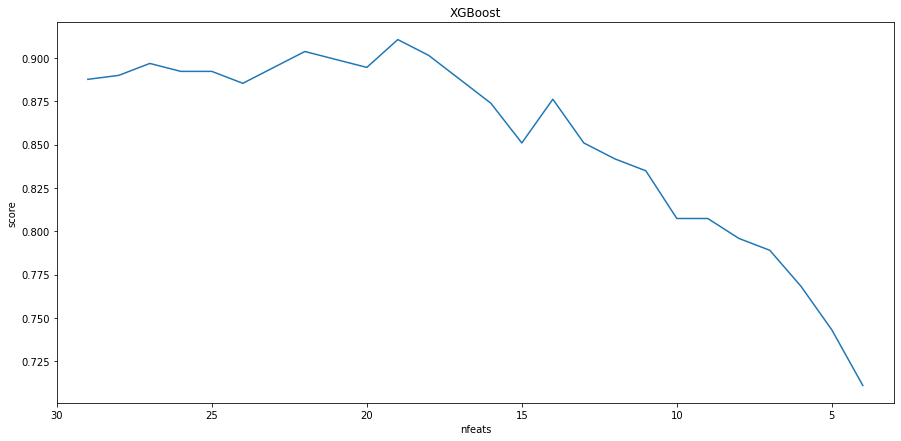

In [26]:
plot_feature_scores(xgb_elim, 'XGBoost')

### Best Extra Trees Feature Importance

average accuracy: 0.8697071277346508 
max accuracy: 0.9197247706422018 minimum feats: 20


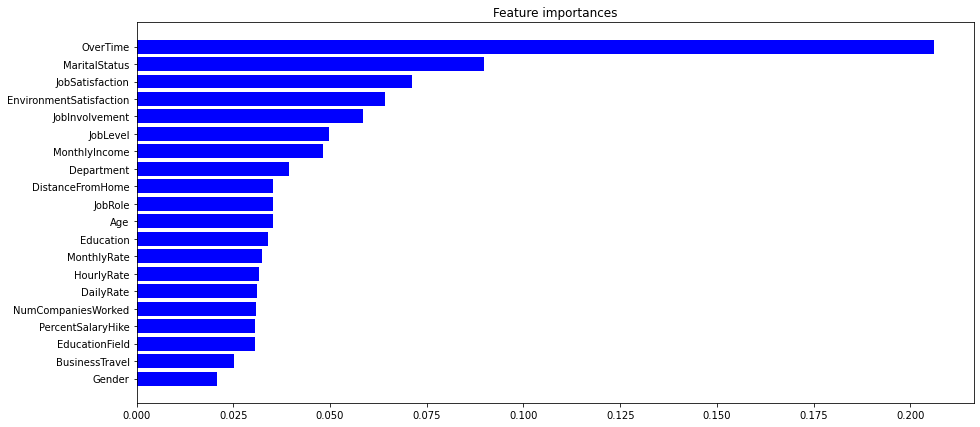

In [27]:
et_elim, et_best = feature_elimination('et', xtrain, ytrain, xtest, ytest)
etbest = et_elim[et_best]
graph_importance(etbest['feats'], etbest['importances'])

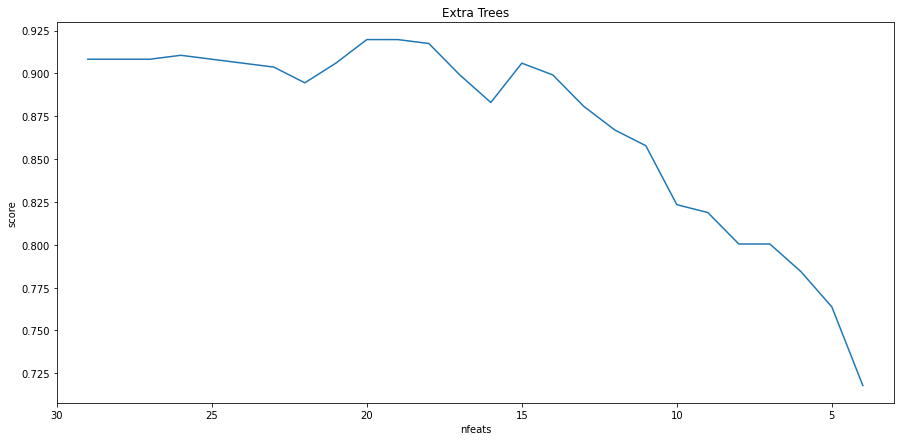

In [28]:
plot_feature_scores(et_elim, 'Extra Trees')

### Best SVM Feature Importance

average accuracy: 0.8561220889202542 
max accuracy: 0.9220183486238532 minimum feats: 20


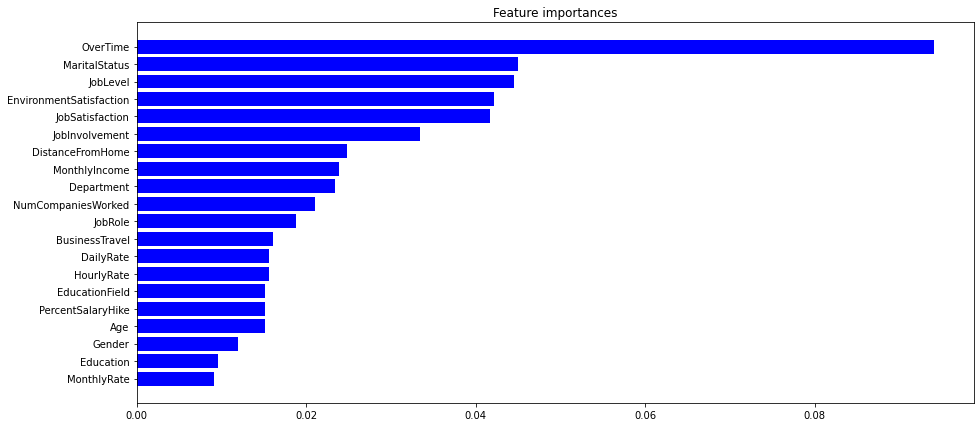

In [29]:
svm_elim, svm_best = feature_elimination('svc', xtrain, ytrain, xtest, ytest)
svmbest = svm_elim[svm_best]
graph_importance(svmbest['feats'], svmbest['importances'])

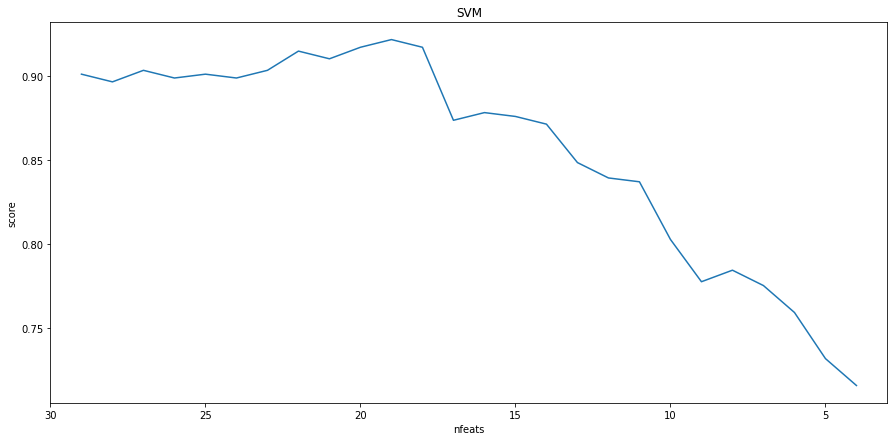

In [30]:
plot_feature_scores(svm_elim, 'SVM')

### Best Logistic Regression Feature Importance

average accuracy: 0.7910197600564572 
max accuracy: 0.8646788990825688 minimum feats: 25


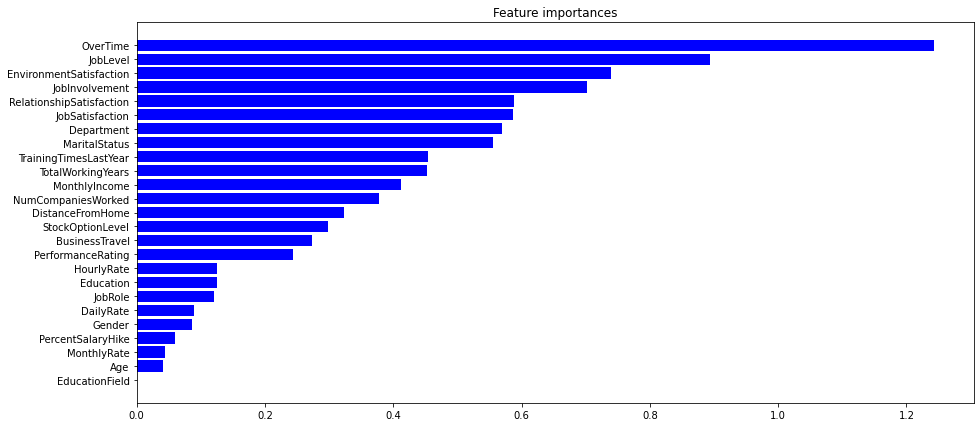

In [33]:
lr_elim, lr_best = feature_elimination('lr', xtrain, ytrain, xtest, ytest)
lrbest = lr_elim[lr_best]
graph_importance(lrbest['feats'], lrbest['importances'])

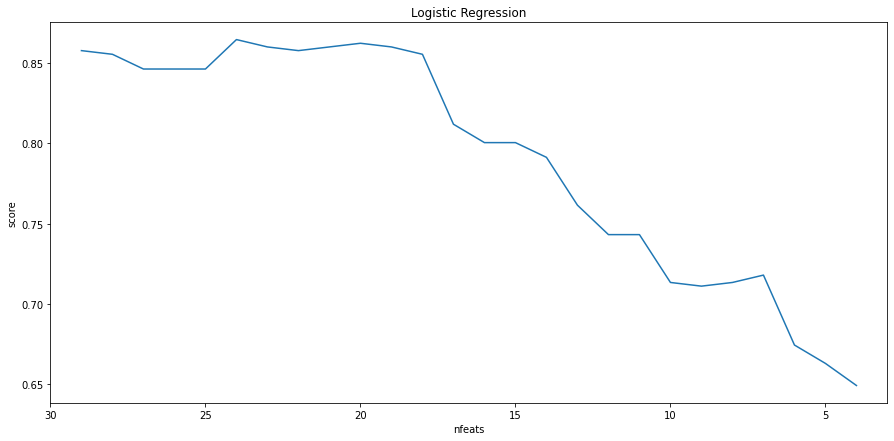

In [35]:
plot_feature_scores(lr_elim, 'Logistic Regression')

### TSNE selected features 

In [36]:
from matplotlib.ticker import NullFormatter
from sklearn.manifold import TSNE

In [50]:
def tsne(_x, _y):
  (fig, subplots) = plt.subplots(1, 3, figsize=(15, 5))
  perplexities = [ 25, 50, 100]
  n_components = 2

  red = _y == 0
  green = _y == 1
  _ = []
  for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    _tsne = TSNE(
        n_components=n_components,
        #method='exact',
        init="random",
        random_state=6,
        perplexity=perplexity,
        learning_rate=200,
        n_iter=2000,
    ).fit_transform(_x, y=_y)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(_tsne[red, 0], _tsne[red, 1], c="r")
    ax.scatter(_tsne[green, 0], _tsne[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    _.append(_tsne)
  return _

## TSNE for Extra Trees and XGBoost

### Extra Trees

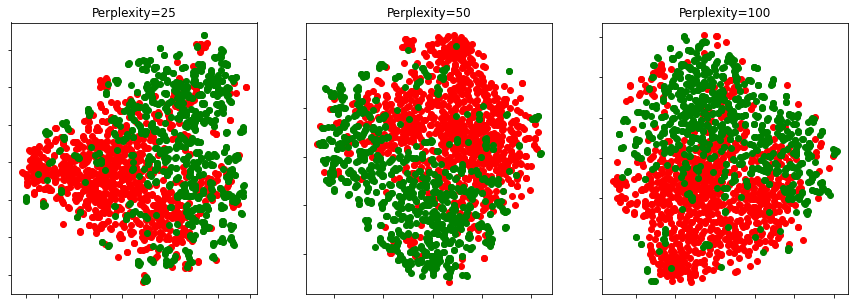

In [51]:
etp25, etp50, etp100 = tsne(xtrain[etbest['feats']], ytrain)

### XGBoost

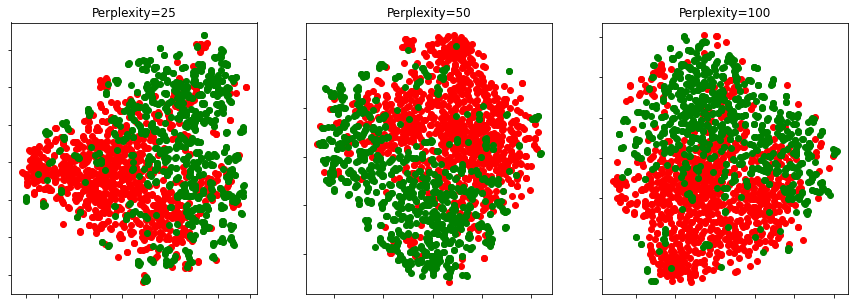

In [52]:
# XGBoost Best Feats TSNE
xgp25, xgp50, xgp100 = tsne(xtrain[etbest['feats']], ytrain)

## PCA for Extra Trees and XGBoost

In [63]:
from sklearn.decomposition import PCA

def pca(_x, _y, _comp, _title):
  _pca = PCA(n_components=_comp).fit(_x, y=_y)
  _ = _pca.transform(_x)
  plt.plot(_pca.explained_variance_, linewidth=3)
  plt.title(_title)
  plt.xlabel('Components')
  plt.ylabel('Explained Variances')
  plt.show()
  return _

### Extra Trees PCA

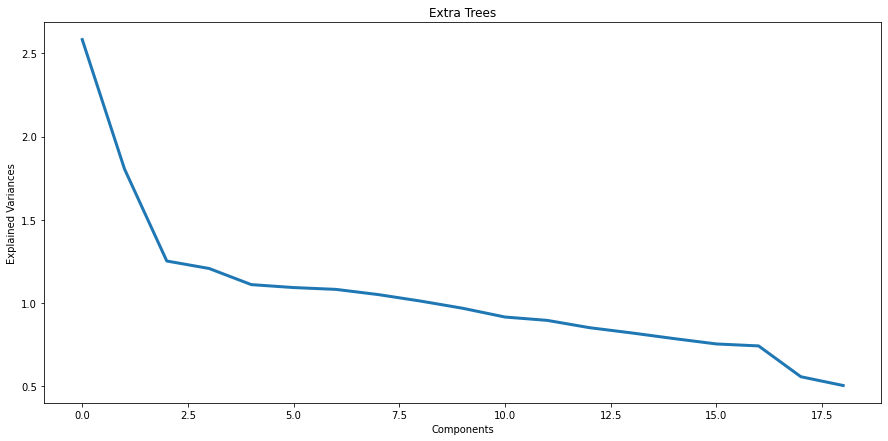

In [65]:
et_pca = pca(xtrain[etbest['feats']], ytrain, 19, 'Extra Trees')

### XGBoost PCA

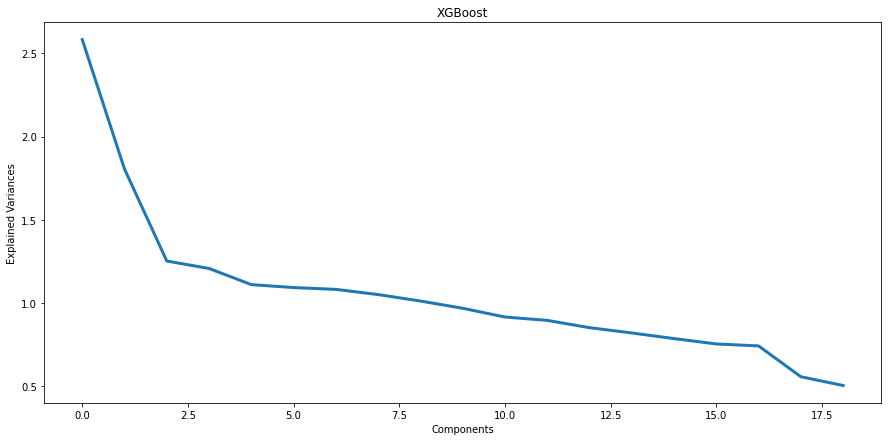

In [66]:
xgb_pca = pca(xtrain[best['feats']], ytrain, 19, 'XGBoost')

## Cross Validation

In [84]:
from sklearn import model_selection

def cross_validate(names, models, _X_train, _y_train, index, cv=3):
  res = []
  for model in models:
    draft = model_selection.cross_val_score(model, _X_train, _y_train, cv=cv)
    res.append(draft)
  index = [index+' CV_' + str(i) for i in range(cv)]
  accuracy = pd.DataFrame(np.array(res).T, 
                          columns=names, 
                          index=index,
                          ).round(decimals=3)
  sum = 0.0
  for i in res[0]:
    sum+=i
  print('Average Score: ' + str(sum/3))
  return accuracy

def get_score(names, models, _X_train, _y_train, _X_test, _y_test, index):
  res = {' ':[index]}
  for n, model in enumerate(models):
    trained = model.fit(_X_train, _y_train)
    score = trained.score(_X_test, _y_test)
    res[names[n]] = score
  df = pd.DataFrame(res).set_index(' ')
  return df

## RAW Features

In [85]:
name = ['Xgboost']#, 'Extra Trees']
model = [XGBClassifier(learning_rate =0.2, objective='binary:logistic', random_state=6, nthread=4),]
          #ExtraTreesClassifier(random_state=6)]
cross_validate(name, model, xtrain[best['feats']], ytrain, 'XGB Best Feats')

Average Score: 0.8943804775753259


,Xgboost
XGB Best Feats CV_0,0.871
XGB Best Feats CV_1,0.907
XGB Best Feats CV_2,0.905


In [86]:
name = ['Extra Trees']
model = [ExtraTreesClassifier(random_state=6)]
cross_validate(name, model, xtrain[etbest['feats']], ytrain, 'Extra Trees Best Feats')

Average Score: 0.9087235642075692


,Extra Trees
Extra Trees Best Feats CV_0,0.886
Extra Trees Best Feats CV_1,0.935
Extra Trees Best Feats CV_2,0.905


## TSNE

In [89]:
name = ['Extra Trees TSNE']
model = [ExtraTreesClassifier(random_state=6)]
cross_validate(name, model, etp100, ytrain, 'Extra Trees TSNE')

Average Score: 0.8874859042079649


,Extra Trees TSNE
Extra Trees TSNE CV_0,0.867
Extra Trees TSNE CV_1,0.907
Extra Trees TSNE CV_2,0.888


In [93]:
name = ['XGBoost TSNE']
model = [XGBClassifier(learning_rate =0.2, objective='binary:logistic', random_state=6, nthread=4),]
cross_validate(name, model, etp100, ytrain, 'XGBoost TSNE')

Average Score: 0.8455922211011534


,XGBoost TSNE
XGBoost TSNE CV_0,0.823
XGBoost TSNE CV_1,0.847
XGBoost TSNE CV_2,0.867


## PCA

In [101]:
name = ['Extra Trees PCA']
model = [ExtraTreesClassifier(random_state=6)]
cross_validate(name, model, et_pca, ytrain, 'Extra Trees PCA')

Average Score: 0.8978099590480147


,Extra Trees PCA
Extra Trees PCA CV_0,0.876
Extra Trees PCA CV_1,0.935
Extra Trees PCA CV_2,0.883


In [95]:
name = ['XGBoost PCA']
model = [XGBClassifier(learning_rate =0.2, objective='binary:logistic', random_state=6, nthread=4),]
cross_validate(name, model, xgb_pca, ytrain, 'XGBoost PCA')

Average Score: 0.8662432983164182


,XGBoost PCA
XGBoost PCA CV_0,0.850
XGBoost PCA CV_1,0.886
XGBoost PCA CV_2,0.862
